# Report 4: Fitting Autoregression model to coffee price data
Alicja Nowakowska

Model: $X(t) = b_0 + b_1X(t-1)+b_2X(t-2)+...+ b_pX(t-p)+\epsilon_t$

We must evaluate how many previous terms are important for the prediction by checking the autocorrelation

# Part 1. Model fitting to original data

## Data

In [1]:
import pandas as pd
coffee = pd.read_csv("coffee.txt", sep ="\t")
coffee.Month=pd.to_datetime(coffee.Month,dayfirst=True)
coffee.set_index("Month",inplace=True)

In [2]:
coffee.head()

,Price,Change
Month,,
2001-08-01,0.57,-
2001-09-01,0.54,-5.26 %
2001-10-01,0.51,-5.56 %
2001-11-01,0.52,1.96 %
2001-12-01,0.54,3.85 %


<AxesSubplot:xlabel='Month'>

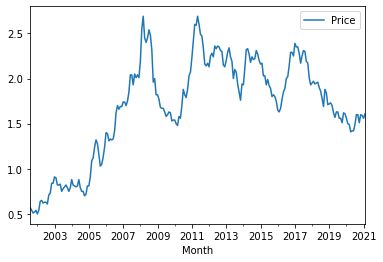

In [8]:
coffee.plot()

## Checking if the time series is stationary
Time series are stationary if they do not have trend or seasonal effects. We use Augmented  Dickey-Fueller Test for stationarity evaluation. The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root (it is non-stationary - have trend/seasonality), with the alternative that there is no unit root (time series is stationary).

In [3]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series, title=''):
    
    print(f'Augmented  Dickey-Fueller Test: {title}')
    result=adfuller(series.dropna(),autolag='AIC')
    labels=['ADF test statistic','p-value','# lags used', '# observations']
    out=pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())
    if result[1]< 0.05:
        print("Strong exidence against the null hypothesis")
        print("Rejected the null hypothesis")
    else:
        print("Weak evidence against the null hypothesis")
        print("Failed to reject the null hypothesis")

In [14]:
adf_test(coffee['Price'])

Augmented  Dickey-Fueller Test: 
ADF test statistic       -2.260833
p-value                   0.184911
# lags used               1.000000
# observations          233.000000
critical value (1%)      -3.458731
critical value (5%)      -2.874026
critical value (10%)     -2.573424
Weak evidence against the null hypothesis
Failed to reject the null hypothesis


## Correlation plot

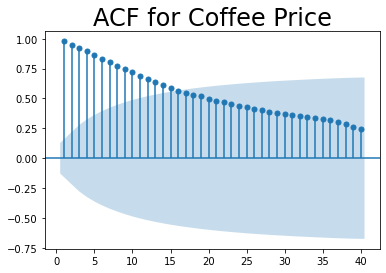

In [7]:
import statsmodels.graphics. tsaplots as sgt
import matplotlib.pyplot as plt
sgt.plot_acf(coffee.Price,lags=40,zero=False)
plt.title("ACF for Coffee Price", size=24)
plt.show()

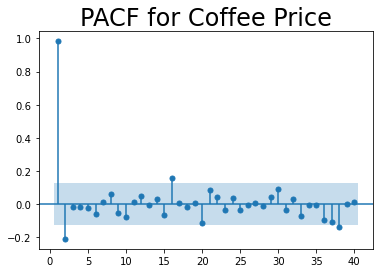

In [12]:
sgt.plot_pacf(coffee.Price,lags=40,zero=False)
plt.title("PACF for Coffee Price", size=24)
plt.show()

Using PACF we can state how many terms are important for the AR model and in the considered case it is 2. 

*rder p is the lag value after which PACF plot crosses the upper confidence interval for the first time. These p lags will act as our features while forecasting the AR time series. We cannot use the ACF plot here because it will show good correlations even for the lags which are far in the past. If we consider those many features, we will have multicollinearity issues.This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.* (https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8)

## Fit the model

In [16]:
from statsmodels.tsa.arima_model import ARMA
model=ARMA(coffee.Price,order=(2,0))
results=model.fit()
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                  235
Model:                     ARMA(2, 0)   Log Likelihood                 242.881
Method:                       css-mle   S.D. of innovations              0.085
Date:                Sat, 01 May 2021   AIC                           -477.761
Time:                        14:12:26   BIC                           -463.923
Sample:                    08-01-2001   HQIC                          -472.182
                         - 02-01-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5018      0.354      4.245      0.000       0.808       2.195
ar.L1.Price     1.2362      0.063     19.621      0.000       1.113       1.360
ar.L2.Price    -0.2496      0.063     -3.937      0.000      -0.374      -0.125
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0183           +0.0000j            1.0183            0.0000
AR.2            3.9349           +0.0000j            3.9349            0.0000
-----------------------------------------------------------------------------
"""

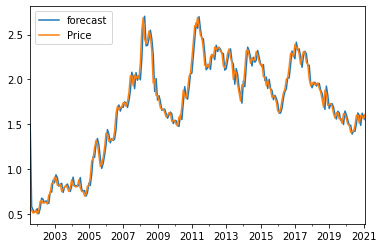

In [26]:
results.plot_predict()
plt.show()

## Residuals
shold have a white noise form

Mean: 0.0020019576654927906
Std: 0.10443937576238413


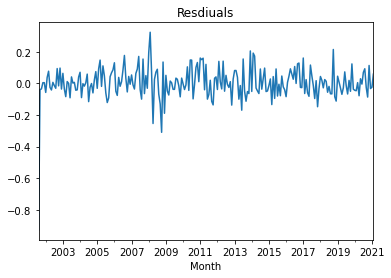

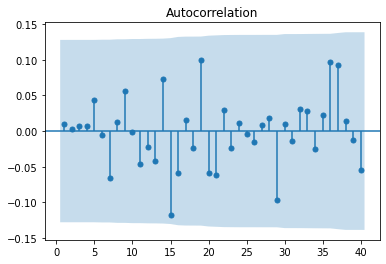

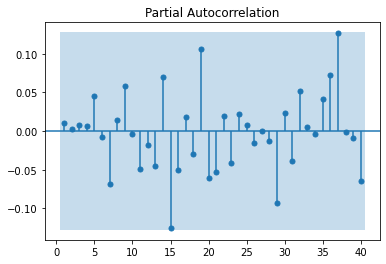

In [33]:
coffee["residuals"] = results.resid
print("Mean:", coffee["residuals"].mean())
print("Std:", coffee["residuals"].std())
coffee["residuals"].plot()
plt.title("Resdiuals")
plt.show()
sgt.plot_acf(coffee.residuals,lags=40,zero=False)
plt.show()
sgt.plot_pacf(coffee.residuals,lags=40,zero=False)
plt.show()

# Part 2. Model fitting to differntiated data
Differencing is used to remove trend or seasonality. We do it by substracting the previous value from the current one.

<AxesSubplot:xlabel='Month'>

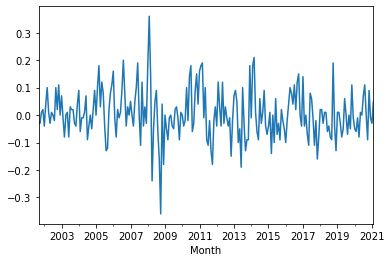

In [4]:
coffee["PriceDiff"] = coffee.Price.diff()
diff = coffee["PriceDiff"][1:]
diff.plot()

In [5]:
adf_test(diff)

Augmented  Dickey-Fueller Test: 
ADF test statistic     -1.188156e+01
p-value                 6.160421e-22
# lags used             0.000000e+00
# observations          2.330000e+02
critical value (1%)    -3.458731e+00
critical value (5%)    -2.874026e+00
critical value (10%)   -2.573424e+00
Strong exidence against the null hypothesis
Rejected the null hypothesis


No non-stationarity problem is no present in contrast to the orginal dataset what should help with fitting.

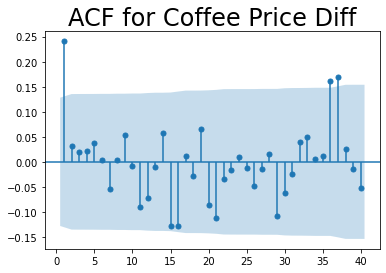

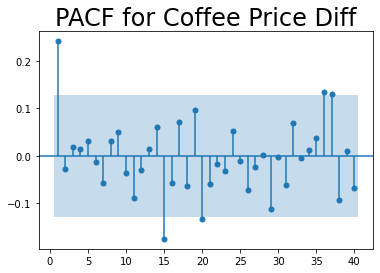

In [8]:
sgt.plot_acf(diff,lags=40,zero=False)
plt.title("ACF for Coffee Price Diff", size=24)
plt.show()
sgt.plot_pacf(diff,lags=40,zero=False)
plt.title("PACF for Coffee Price Diff", size=24)
plt.show()

In [10]:
from statsmodels.tsa.arima_model import ARIMA
model2=ARIMA(diff,order=(1,1,0)) # 1 and 1 comes from number of sticks above the blue region from ACF and PACF plot
results2=model2.fit()
results2.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS wi

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.PriceDiff   No. Observations:                  233
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 202.296
Method:                       css-mle   S.D. of innovations              0.102
Date:                Mon, 03 May 2021   AIC                           -398.591
Time:                        18:05:42   BIC                           -388.238
Sample:                    10-01-2001   HQIC                          -394.416
                         - 02-01-2021                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0003      0.005      0.052      0.959      -0.009       0.010
ar.L1.D.PriceDiff    -0.3610      0.061     -5.921      0.000      -0.480      -0.241
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.7703           +0.0000j            2.7703            0.5000
-----------------------------------------------------------------------------
"""

Mean: -3.848829579911467e-07
Std: 0.10174262846665903


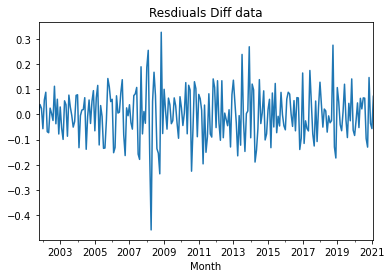

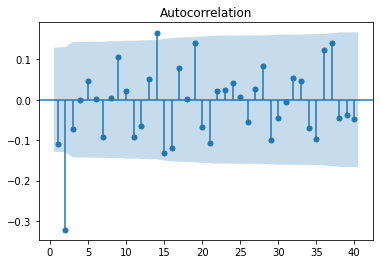

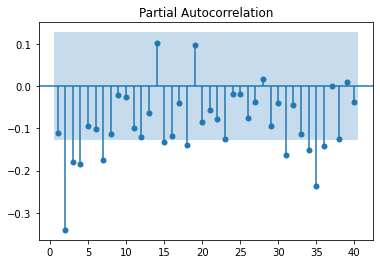

In [11]:
new = pd.DataFrame()
new["residuals2"] = results2.resid
print("Mean:", new["residuals2"].mean())
print("Std:", new["residuals2"].std())
new["residuals2"].plot()
plt.title("Resdiuals Diff data")
plt.show()
sgt.plot_acf(new.residuals2,lags=40,zero=False)
plt.show()
sgt.plot_pacf(new.residuals2,lags=40,zero=False)
plt.show()

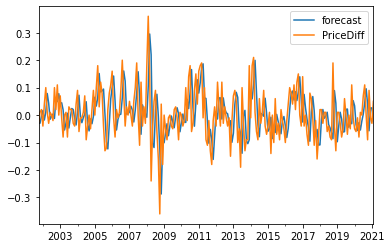

In [12]:
results2.plot_predict()
plt.show()

The second model is recommended since it accounts for non-stationarity.